In [127]:
import numpy as np
from PIL import Image
import torch
from torchsummary import summary
import matplotlib.pyplot as plt
from PIL import ImageFilter
from scipy.ndimage import label

3215 2136


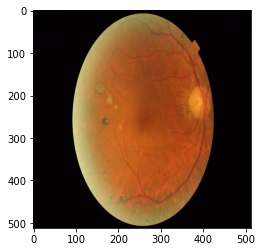

In [128]:
model = torch.load('../logs/version5/checkpoints/model.pth')
# summary(model, input_size=(1, 128, 128), batch_size=-1)
img_orig = Image.open('../dataset/roi_retina/1/217_right.jpeg')
# img_orig = Image.open('../dataset/roi_retina/0/17967_left.jpeg')
h, w = img_orig.size
img = img_orig.resize((512, 512)).convert('RGB')
img = np.array(img)
img_orig = np.array(img_orig).astype('float')
print(h, w)
plt.figure()
plt.imshow(img, cmap='gray')

In [129]:
def add_zerosboxes(img):
    """
    Add zero boxes to the retina image to adjust the size to nxn resolution.

    :param img: numpyarray, The image.
    :return: Numpy array (image) with zeros boxes.
    """
    h, w, c = img.shape
    axis = 0
    b = abs(int(h - w))
    b1 = int(b / 2)
    b2 = b - b1
    if h > w:
        axis = 1
        z1 = np.zeros((h, b1, c))
        z2 = np.zeros((h, b2, c))
    elif w > h:
        z1 = np.zeros((b1, w, c))
        z2 = np.zeros((b2, w, c))
    else:
        return img
    newimg = np.append(img, z1, axis=axis)
    newimg = np.append(z2, newimg, axis=axis)
    return newimg

def remove_remaining(prediction):
    '''
    Remove the remaining groups of prediction pixels.
    :param prediction: Pillow Image, prediction (segmentation) of the model.
    :return: Pillow Image.
    '''
    prediction = np.array(prediction)
    labels, features = label(prediction)
    h, w = prediction.shape
    groups = np.unique(labels)

    # Since label method converts the values of the matrix, we don't know which
    # ones are the black pixels so it will help to identify them by pixel counter.
    # Most of the times zeros of labels means zeros of the prediction but it
    # could change so we must ensure.
    zeros_counter = prediction[(prediction == 0)].size
    zeros_id = 0

    remainings = []
    for group in groups:
        count = labels[(labels == group)].size
        if count == zeros_counter:
            zeros_id = group
        percentage = count/(h*w)
        if percentage < 0.30:
            remainings.append(group)

    for remaining_group in remainings:
        labels = np.where(labels==remaining_group, zeros_id, labels)

    # Reconvert to binary format
    labels = np.where(labels != zeros_id, 255, labels)
    labels = np.where(labels == zeros_id, 0, labels)
    return Image.fromarray(labels.astype(np.uint8))

torch.Size([1, 3, 512, 512])
[Elapsed time]: 28.32174301147461ms
2135 3214
0 0
(2136, 3215)
1.0
(3214, 3214, 3)


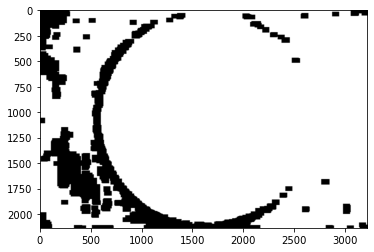

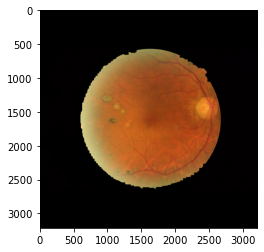

In [130]:
from time import time
image = np.transpose(img, (2, 0, 1))
# image = np.expand_dims(img, axis=0)
image = np.expand_dims(image, axis=0)
image = torch.tensor(image, device='cuda', dtype=torch.float)
print(image.shape)
start = time()
with torch.no_grad():
    pred = model(image)
stop = time()
et = stop - start
print('[Elapsed time]: '+ str(et*1000) + 'ms')
pred = pred.detach().cpu().squeeze(0).squeeze(0).numpy()
pred = np.where(pred > .5, 1, 0).astype('float')
pred = Image.fromarray(pred)
pred = pred.filter(ImageFilter.MinFilter(11))
pred = remove_remaining(pred)
pred = pred.resize((h, w))
pred = np.array(pred) / 255.
pos = np.where(pred)
print(np.max(pos[0]), np.max(pos[1]))
print(np.min(pos[0]), np.min(pos[1]))
xmin = np.min(pos[1])
xmax = np.max(pos[1])
ymin = np.min(pos[0])
ymax = np.max(pos[0])
print(pred.shape)
plt.figure()
plt.imshow(pred, cmap='gray')
pred = np.expand_dims(pred, axis=-1)
print(np.max(pred))
pred = np.repeat(pred, 3, axis=-1)
img_mult = np.multiply(img_orig / 255., np.array(pred))
crop = img_mult[ymin:ymax, xmin:xmax]
crop = add_zerosboxes(crop)
print(crop.shape)
plt.figure()
plt.imshow(crop, cmap='gray')